In [12]:
import scipy.io.wavfile as wav
import numpy as np
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
import math 
%matplotlib inline
import librosa
import midiutil
import sys
from scipy.interpolate import interp1d



y, sr = librosa.load('vocals.wav')
print(y.shape)
print(sr)
voiced_acc = 0.9
onset_acc = 0.8
frame_length=2048
window_length=1024
hop_length=256
pitch_acc = 0.99
spread = 0.6


f0, voiced_flag, voiced_probs = librosa.pyin(y,librosa.note_to_hz('C2'),librosa.note_to_hz('C7'),sr,frame_length, window_length, hop_length)
#f0 = np.nan_to_num(f0)
#0_ = np.round(librosa.hz_to_midi(f0)).astype(int)
f0_ = np.where(f0_ == -2147483648, 0,f0_)
#f0_new = np.nan_to_num(f0)
onsets = librosa.onset.onset_detect(y, sr=sr, hop_length=hop_length, backtrack=True)
print(f0_[:30])

print(f0_.shape)
print(onsets)

silence = 0
onset = 1
sustain = 2
my_state = silence

last_onset = 0
last_offset = 0
last_midi = 0
output = []
hop_time = hop_length/sr

# for loop inspired by audio_to_mid repo 
# https://github.com/tiagoft/audio_to_midi/blob/1f337672de6942dcd97b9b5b6617f5e84c0e6c5a/audio2midi.py#L145
for i in range(len(f0_)):
        if my_state == silence:
            if int(f0_[i]%2) != 0:
                # Found an onset!
                last_onset = i * hop_time
                last_midi = ((f0_[i]-1)/2)
                my_state = onset


        elif my_state == onset:
            if int(f0_[i]%2) == 0:
                my_state = sustain

        elif my_state == sustain:
            if int(f0_[i]%2) != 0:
                # Found an onset.                
                # Finish last note
                last_offset = i*hop_time
                my_note = [last_onset, last_offset, last_midi]
                output.append(my_note)
                
                # Start new note
                last_onset = i * hop_time
                last_midi = ((f0_[i]-1)/2)
                my_state = onset
            
            elif f0_[i]==0:
                # Found silence. Finish last note.
                last_offset = i*hop_time
                my_note = [last_onset, last_offset, last_midi]
                output.append(my_note)
                my_state = silence


print(output)

MyMIDI = midiutil.MIDIFile(1)
bpm = librosa.beat.tempo(y)[0]
MyMIDI.addTempo(0, 0, bpm)

onsets = np.array([p[0] for p in output])
offsets = np.array([p[1] for p in output])
quarter_note = 60/bpm
ticks_per_quarter = 1024
onsets = onsets / quarter_note
offsets = offsets  / quarter_note


for i in range(len(onsets)):
        print(f0_[i], onsets[i])
        MyMIDI.addNote(0, 0, f0_[i], onsets[i], 1, 100)

with open("output.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file)




[         nan          nan 372.1377786  ... 325.8414615  311.12698372
 311.12698372]


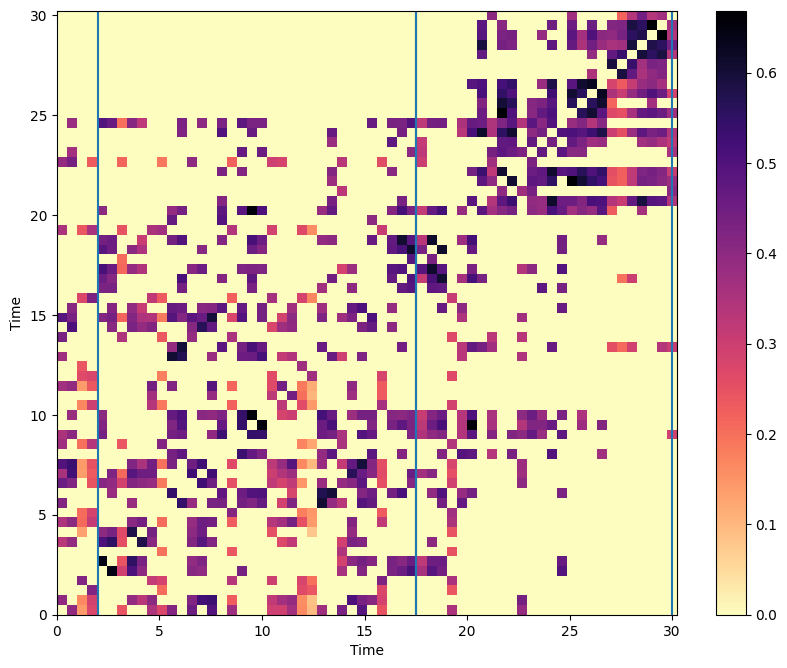

In [49]:
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.interpolate import interp1d
def smooth_features(x, sr, hop_length, filter_length=21, downsample_hz=2):
    """
    Apply temporal smoothing to a frame-by-frame feature array
    """
    
    # Apply median smoothing
    smoothed = medfilt(x, kernel_size=(1,filter_length))
    
    # Downsample the smoothed signal
    downsample_rate = int((sr / hop_length) / downsample_hz)
    smoothed = smoothed[:, ::downsample_rate]
    
    # The update length in samples between features
    step_size = downsample_rate * hop_length
    
    return smoothed, step_size
x, sr = librosa.load("input_songs/pop.00000.wav")
y, sr = librosa.load("input_songs/pop.00000.wav")
# Calculate MFCCs
hop_length = 512
tt_1_mfcc = librosa.feature.mfcc(x, hop_length=hop_length)
tt_2_mfcc = librosa.feature.mfcc(y, hop_length=hop_length)



# Perform temporal smoothing
mfccs_smoothed_1, smoothed_hop_1 = smooth_features(tt_1_mfcc, 22050, hop_length)
mfccs_smoothed_2, smoothed_hop_2 = smooth_features(tt_2_mfcc, 22050, hop_length)
ssm_mfccs = librosa.segment.cross_similarity(mfccs_smoothed_1, mfccs_smoothed_2, mode="affinity")

fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
imgaff = librosa.display.specshow(ssm_mfccs, x_axis='time', y_axis='time',
                         cmap='magma_r', hop_length=smoothed_hop_1, ax=ax)
fig.colorbar(imgaff)

ax.axvline(2)
ax.axvline(17.5)

ax.axvline(17.5)
ax.axvline(30)